# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 20.05.2023**

**Мягкий дедлайн: 03.06.2023 23:59 MSK**

**Жёсткий дедлайн: 08.06.2023 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов + **2.5** бонусных.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендации музыки. То есть мы поставим целью получить модель, которая для каждого пользователя будет возвращать набор треков, наиболее похожих на те, что он уже слушал. В первой части мы разберемся с memory-based подходом и моделью со скрытыми переменными. Это не очень мощные методы, но зато они позволяют строить предсказания почти моментально. Затем, во второй части, мы обратим внимание на то, что датасет содержит огромное число треков и воспользуемся результатами уже построенных быстрых моделей для сокращения списка кандидатов до разумного количества. После этого проведем ранжирование среди кандидатов с помощью сильной, но чуть более медленной модели, и отберем самые лучшие варианты. Такой двухэтапный алгоритм построения рекомендаций изображен на картинке.


![photo_2023-05-17%2020.06.18.jpeg](attachment:photo_2023-05-17%2020.06.18.jpeg)

Приступим!

Все шаблоны ниже можно переписывать по своему усмотрению.

### часть 0

In [ ]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [ ]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [ ]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']
...,...,...,...
72378,72378,Будь что будет,['Suleeking Nazlim']
72379,72379,The Joker And The Queen,"['Ed Sheeran', 'Taylor Swift']"
72380,72380,Пiдманула,"['TAMUKI', 'Andery Toronto']"
72381,72381,Этот мир обдолбан,"['СЭТ', 'PLC']"


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балл).** Реализуйте метрику $MAP@k$.

In [ ]:
def precisionk(relevant: List[int], predicted: List[int], k: int = 20):
  return 1/k * np.sum([predicted[i] in relevant for i in range(k)])

def apk(relevant: List[int], predicted: List[int], k: int = 20):
    return 1/min(k, len(relevant)) * np.sum([(predicted[i] in relevant) * precisionk(relevant, predicted, i + 1) for i in range(k)])

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    n = len(relevant)
    return 1/n * np.sum([apk(relevant[i], predicted[i], k) for i in range(n)])

In [ ]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [ ]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [ ]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

In [ ]:
train_ratings

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404
...,...,...
129399,240,68218
129400,240,68236
129401,240,68304
129402,240,68362


In [ ]:
test_ratings[test_ratings['userId'] == 10]

,userId,trackId
276,10,70629
277,10,70713
278,10,70964
279,10,70967
280,10,71065


Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [ ]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [ ]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [ ]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [ ]:
train_ratings

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404
...,...,...
129399,240,65424
129400,240,65436
129401,240,65480
129402,240,65515


In [ ]:
test_ratings[test_ratings['userId'] == 0]

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168
5,0,59334
6,0,59838
7,0,60940
8,0,62167
9,0,62924


In [ ]:
tracks_info.iloc[test_ratings[test_ratings['userId'] == 0]['trackId']]

,id,name,artists
57582,57582,Scary Little Green Men,['Ozzy Osbourne']
57802,57802,Малолетка,['Макс Корж']
57957,57957,Beggin',['Shocking Blue']
58174,58174,Switch,['Biig Piig']
59168,59168,Living In A Ghost Town,['The Rolling Stones']
59334,59334,Sunday,['Lonely God']
59838,59838,Не переживай!,"['SunSay', 'The Soul Surfers']"
60940,60940,Don't Look At Me,['POORSTACY']
62167,62167,Master Of Ceremony,"['Lowriderz', 'Smoky D']"
62924,62924,Ghoul,"['REDZED', 'Gizmo']"


Соберем все релевантные треки для каждого пользователя в список.

In [ ]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [ ]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.user_ids = np.unique(self.ratings['userId'])
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        return self.remove_train_items([self.recommend(uid) for uid in self.user_ids], k)

### Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать меру Жаккара:

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функция принимает матрицу оценок и вектор оценок пользователя $u$ и возвращает вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [ ]:
def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
  # ratings: num_users x num_tracks прослушал/нет 
  # user_vector: num_tracks x 1 - просулшал/нет
  return ratings.dot(user_vector) / np.sum(np.logical_or(ratings, user_vector).astype(int), axis = 1)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок. Значение парамметра `alpha` можно менять по своему усмотрению так, чтобы оно было разумным.

In [ ]:
class User2User(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.similarity_func = jaccard
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        returns N(u) based of self.Ratings
        """
        similarity_vector = self.similarity_func(self.R, user_vector)
        # зачем рекомендовать человеку то, что слушают люди 
        # с абсолютно таким же вкусом, как у него 
        return self.R[(similarity_vector > self.alpha) * (similarity_vector != 1)]

    def recommend(self, uid: int):
      user = self.R[uid]
      N_u = self.similarity(user)
      similarity_vector = self.similarity_func(N_u, user)
      r_hat = similarity_vector.dot(N_u)/np.sum(np.abs(similarity_vector))
      return np.argsort(-r_hat)

**Задание 5 (0.5 балл).** Постройте график зависимости значений $MAP@k$ от разных $k$ при рекомендации на основе меры Жаккара, сравните его с рекомендициями самых популярных треков и случайных. Какой из трех способов рекомендаций оказался лучшим?

In [ ]:
%%time
u2u = User2User(train_ratings)

mapk_history_jaccard = []
k_grid = [1,3,5,8,10,20,40,60,100]

for k in k_grid:
  mapk_history_jaccard.append(mapk(test_relevant, u2u.get_test_recommendations(k), k))

mapk_history_jaccard

CPU times: user 2min 51s, sys: 2min 52s, total: 5min 43s
Wall time: 3min 51s


[0.0,
 0.002482269503546099,
 0.002127659574468085,
 0.0021244934143870315,
 0.0020069233367105708,
 0.001765962631164199,
 0.0016863010949002375,
 0.0017392069649604781,
 0.0018154389250565437]

In [ ]:
%time 
mapk_history_popular = []
k_grid = [1,3,5,8,10,20,40,60,100]
most_popular_tracks = np.argsort(-np.bincount(train_ratings['trackId']))

for k in k_grid:
  mapk_history_popular.append(mapk(test_relevant, [most_popular_tracks[:k] for u in test_users], k))

mapk_history_popular

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


[0.0,
 0.0,
 0.00021276595744680854,
 0.00013297872340425532,
 0.0002765957446808511,
 0.0005034061216871967,
 0.00038665828056485825,
 0.00041923456978703075,
 0.000525593637144424]

In [ ]:
%time 
mapk_history_random = []
k_grid = [1,3,5,8,10,20,40,60,100]
all_tracks = pd.unique(tracks_info['id'])

for k in k_grid:
  mapk_history_random.append(mapk(test_relevant, [np.random.choice(all_tracks, k, replace = False) for u in test_users], k))

mapk_history_random

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


[0.00425531914893617,
 0.0,
 0.00028368794326241134,
 0.00026595744680851064,
 0.0004964539007092199,
 4.255319148936171e-05,
 8.22524367580688e-06,
 4.676174888940847e-06,
 4.5947753604540085e-05]

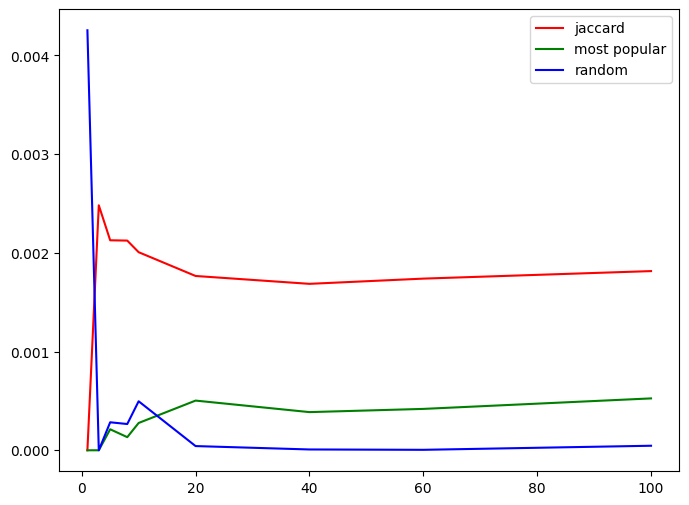

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6), dpi = 100)

plt.plot(k_grid, mapk_history_jaccard, color='r', label='jaccard')
plt.plot(k_grid, mapk_history_popular, color='g', label='most popular')
plt.plot(k_grid, mapk_history_random, color='b', label='random')

plt.legend()

fig.show()

**Бонус (1 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [ ]:
from scipy.sparse import csc_matrix

def jaccard_sparse(ratings: csc_matrix, user_vector: np.array) -> np.array:
  # ratings: num_users x num_tracks прослушал/нет 
  # user_vector: num_tracks x 1 - просулшал/нет
    return ratings.dot(user_vector) / np.sum(ratings + user_vector, axis = 1)

class User2UserSparse(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        self.R = csc_matrix(self.R)

        self.similarity_func = jaccard_sparse
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        returns N(u) based of self.Ratings
        """
        similarity_vector = self.similarity_func(self.R, user_vector)
        # зачем рекомендовать человеку то, что слушают люди 
        # с абсолютно таким же вкусом, как у него 
        return self.R[(similarity_vector > self.alpha * (similarity_vector != 1))]

    def recommend(self, uid: int):
      user = self.R[uid]
      N_u = self.similarity(user)
      similarity_vector = self.similarity_func(N_u, user)
      r_hat = similarity_vector.dot(N_u)/np.sum(np.abs(similarity_vector))
      return np.argsort(-r_hat)

In [ ]:
%%time
u2u_sparse = User2UserSparse(train_ratings)

mapk_history_jaccard_sparse = []
k_grid = [1,3,5,8,10,20,40,60,100]

for k in k_grid:
  mapk_history_jaccard_sparse.append(mapk(test_relevant, u2u.get_test_recommendations(k), k))

mapk_history_jaccard_sparse

CPU times: user 2min 53s, sys: 2min 52s, total: 5min 45s
Wall time: 3min 36s


[0.0,
 0.002482269503546099,
 0.002127659574468085,
 0.0021244934143870315,
 0.0020069233367105708,
 0.001765962631164199,
 0.0016863010949002375,
 0.0017392069649604781,
 0.0018154389250565437]

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [ ]:
user_id = np.random.randint(0, u2u.n_users)

In [ ]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
61,Ain't No Mountain High Enough,"['Marvin Gaye', 'Tammi Terrell']"
177,Paper Planes,['M.I.A.']
186,Soon We'll Be Found,['Sia']
212,Let's Get It Started,['Black Eyed Peas']
220,I Was Made For Lovin' You,['Kiss']
222,I Go To Sleep,['Sia']
229,Linger,['The Cranberries']
234,Wind Of Change,['Scorpions']
418,Without Me,['Eminem']
582,The Winner Takes It All,['ABBA']


In [ ]:
preds = u2u.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
53102,Аugust,['Intelligency']
47846,Cradles,['Sub Urban']
29105,Human,"[""Rag'n'Bone Man""]"
11493,The Show Must Go On,['Queen']
35656,I Got Love,"['Miyagi & Эндшпиль', 'Рем Дигга']"
48182,Сансара,"['Баста', 'Скриптонит', 'Диана Арбенина', 'Сер..."
38212,Горы по колено,['Макс Корж']
419,The Real Slim Shady,['Eminem']
18070,Dernière danse,['Indila']
39597,Люби меня люби,['гречка']


In [ ]:
test_tracks = test_ratings[test_ratings['userId'] == user_id]['trackId'][:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
66746,Just for me,['PinkPantheress']
66782,Улетаю прочь,['Amirchik']
66806,Toxic,['BoyWithUke']
66808,internet l0ve nightcore,['gitarakuru']
66845,Ты со мной,"['Lina Lee', 'Ваня Дмитриенко']"
66861,dreamcore//,['Pathetic']
66874,У России три пути,"['GSPD', 'DEAD BLONDE']"
66887,GOLD MERCURY TOK,['Sekiz']
66937,Better wash my mouth out with the soap,['Sobertune']
66982,MONEY,['LISA']


### Часть 2. Модель со скрытыми переменными: ALS

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

__P. S.__ Заметьте, что описанная модель предназначена для работы только с __явной__ информацией. В нашем случае от модели будет требоваться всегда возвращать 1, так как мы считаем ошибку только по парам, о которых получили фидбек. Поэтому логично подумать, что постановка задачи не имеет смысла. Однако, на практике оказывается, что из-за случайности в инициализации матриц $P$ и $Q$, обученные векторы для всех треков и пользователей в конце обучения получаются разными. Поэтому модель все же не лишена смысла.

__P. P. S.__ Для более разумной работы с неявной информацией был предложен метод iALS, его описание можно найти в лекции. Ниже будет бонус на его реализацию.

**Задание 6 (0.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

$\nabla_{p_u}\left[\sum_{u, i}\left(\left\langle p_u, q_i\right\rangle - r_{u i}\right)^2 + \lambda\left(\sum_{u \in U}\left\|p_u\right\|^2+\sum_{i \in I}\left\|q_i\right\|^2\right)\right]=\sum_i 2\left(\left\langle p_u, q_i\right\rangle - r_{u i}\right) q_i + 2 \lambda p_u$

$p_u \leftarrow p_u - \eta \nabla_{p_u}$

$p_u \leftarrow p_u - 2\eta(\sum_i(\langle p_u, q_i\rangle - r_{ui})q_i + \lambda p_u)$

$P \leftarrow P - 2\eta ((P^TQQ^T - RQ^T)^T + \lambda P) = P - 2\eta (QQ^TP - QR^T + \lambda P)$

аналогично:

$Q \leftarrow Q - 2\eta ((Q^TPP^T - R^TP^T)^T + \lambda Q) = Q - 2\eta (PP^TQ - PR + \lambda Q) $

**ALS:**

$\nabla_{p_u}\left[\sum_{u, i}\left(\left\langle p_u, q_i\right\rangle - r_{u i}\right)^2 + \lambda\left(\sum_{u \in U}\left\|p_u\right\|^2+\sum_{i \in I}\left\|q_i\right\|^2\right)\right]=\sum_i 2\left(\left\langle p_u, q_i\right\rangle - r_{u i}\right) q_i + 2 \lambda p_u=0$

$\sum_i \left(\left\langle p_u, q_i\right\rangle - r_{u i}\right) q_i + \lambda p_u=0$

$\sum_i (p_u^Tq_iq_i) - \sum_i r_{u i}q_i + \lambda p_u=0$

$(\sum_i q_iq_i^T)p_u - \sum_i r_{u i}q_i + \lambda p_u=0$

$p_u = \frac{\sum_i q_i r_{ui}}{[\sum_i q_i q_i^T] + \lambda}$

$P = \frac{1}{tr(Q^TQ) + \lambda}QR^T$

аналогично:

$Q = \frac{1}{tr(P^TP) + \lambda}PR$


**Задание 7 (1.5 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [ ]:
class LatentFactorModel(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', lr = 0.0003, lamb = 0.01, eps = 10e-8, b1 = 0.9, b2 = 0.999):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(self.dim, self.n_users))
        self.Q = np.random.normal(size=(self.dim, self.n_items))

        # print(self.dim, self.n_users, self.n_items)
        # print(f'p {self.P}','\n', f'q {self.Q}', '\n\n')

        self.lr = lr
        self.lamb = lamb
        self.eps = eps

        #adam 
        # self.b1 = b1
        # self.b2 = b2
        # self.M = [np.zeros_like(self.P), np.zeros_like(self.Q)]
        # self.V = [np.zeros_like(self.P), np.zeros_like(self.Q)]

    def fit(self, num_iters=200):

        previous_loss = 0
        for epoch in tqdm(range(num_iters)):
            if self.mode == 'sgd':
                grad_p = self.Q.dot((self.P.T.dot(self.Q)*self.R - self.R).T) + self.lamb*self.P
                grad_q = self.P.dot(self.P.T.dot(self.Q)*self.R - self.R) + self.lamb*self.Q

                # adam
                # self.M[0] = self.b1 * self.M[0] + (1-self.b1) * grad_p
                # self.M[1] = self.b1 * self.M[1] + (1-self.b1) * grad_q

                # self.V[0] = self.b2 * self.V[0] + (1-self.b2) * grad_p**2
                # self.V[1] = self.b2 * self.V[1] + (1-self.b2) * grad_q**2

                # M_hat = [self.M[0]/(1-self.b1), self.M[1]/(1-self.b1)]
                # V_hat = [self.V[0]/(1-self.b2), self.V[1]/(1-self.b2)]

                # self.P = self.P - self.lr/(np.sqrt(V_hat[0]) + 10e-8)*M_hat[0]
                # self.Q = self.Q - self.lr/(np.sqrt(V_hat[1]) + 10e-8)*M_hat[1]

                self.P = self.P - self.lr * 2 * grad_p
                self.Q = self.Q - self.lr * 2 * grad_q

                current_loss = np.linalg.norm(self.P.T.dot(self.Q) - self.R)**2 + self.lamb*(np.linalg.norm(self.P)**2 + np.linalg.norm(self.Q)**2)

                if(np.abs(previous_loss - current_loss)/(previous_loss + 10e-8) <= self.eps):
                  self.lr = self.lr / 2
                  self.eps = self.eps * 0.1
                  print(f'loss difference < {self.eps}, learning rate halved: {self.lr}, epsilon changed: {self.eps}')

                if(self.eps <= 10e-8):
                  print(f'epsilon < 10e-8: {self.eps}')
                  return self

                previous_loss = current_loss
                # if(epoch%10 == 0):
                # print(f'grad_p {grad_p}', '\n', f'grad_q {grad_q}', '\n\n')
              

            elif self.mode == 'als':
                self.P = 1/(np.trace(self.Q.dot(self.Q.T)) + self.lamb) * self.Q.dot(self.R.T)
                self.Q = 1/(np.trace(self.P.T.dot(self.P)) + self.lamb) * self.P.dot(self.R)

                current_loss = np.linalg.norm(self.P.T.dot(self.Q) - self.R)**2 + self.lamb*(np.linalg.norm(self.P)**2 + np.linalg.norm(self.Q)**2)

                if(np.abs(previous_loss - current_loss)/(previous_loss + 10e-8) <= self.eps):
                  self.lr = self.lr / 2
                  self.eps = self.eps * 0.1
                  print(f'loss difference < {self.eps}, learning rate halved: {self.lr}, epsilon changed: {self.eps}')

                if(self.lr < 10e-8):
                  print(f'learning rate < 10e-8: {self.lr}')
                  return self
                
                previous_loss = current_loss

            if(epoch%10 == 0):
            # print(f'p {self.P}','\n', f'q {self.Q}', '\n\n')
              print(f'epoch: {epoch}, ' +
                    f'loss: {np.linalg.norm(self.P.T.dot(self.Q) - self.R)**2 + self.lamb*(np.linalg.norm(self.P)**2 + np.linalg.norm(self.Q)**2)}, '+ 
                    f'|P^TQ - R|: {np.linalg.norm(self.P.T.dot(self.Q) - self.R)**2 }')
            
        return self

    def recommend(self, uid):
        pred_rating = self.P.T[uid].dot(self.Q)

        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

__P. S.__ Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

__P. P. S.__ Методу SGD свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [ ]:
top_score = -1
top_dim = -1
top_lfm_sgd = None
dim_grid = [5, 10, 16, 20, 25, 32, 64, 128]

for dim in dim_grid:
  lfm_sgd = LatentFactorModel(train_ratings, mode = 'sgd', dim = dim, lr = 0.0002, lamb = 0.05, eps = 10e-6).fit(200)
  score = mapk(test_relevant, lfm_sgd.get_test_recommendations(20), 20)
  if score > top_score:
    top_score = score
    top_dim = dim
    top_lfm_sgd = lfm_sgd

dim, top_score

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 59170567.65698336, |P^TQ - R|: 59153619.4888329
epoch: 10, loss: 12070143.67193118, |P^TQ - R|: 12053342.251110425
epoch: 20, loss: 7094612.671928789, |P^TQ - R|: 7077879.078954294
epoch: 30, loss: 4272131.573134287, |P^TQ - R|: 4255458.74863193
epoch: 40, loss: 1650773.6662031447, |P^TQ - R|: 1634149.33179981
epoch: 50, loss: 1569467.1255399091, |P^TQ - R|: 1552872.3118867313
epoch: 60, loss: 1024991.2749345606, |P^TQ - R|: 1008416.3017221427
epoch: 70, loss: 1399874.6297859668, |P^TQ - R|: 1383324.6344262806
epoch: 80, loss: 681063.0091211197, |P^TQ - R|: 664532.9680184124
epoch: 90, loss: 568537.9214054546, |P^TQ - R|: 552015.6237202876
epoch: 100, loss: 555831.0491846967, |P^TQ - R|: 539315.4208321117
epoch: 110, loss: 551951.7783876691, |P^TQ - R|: 535442.7621473256
epoch: 120, loss: 550969.4054576874, |P^TQ - R|: 534466.9925039598
epoch: 130, loss: 551639.4249173152, |P^TQ - R|: 535143.6100170718
epoch: 140, loss: 553336.1776401311, |P^TQ - R|: 536846.9565845595
e

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 109323344.09150745, |P^TQ - R|: 109289589.47849263
epoch: 10, loss: 22897256.992245875, |P^TQ - R|: 22863700.747313343
epoch: 20, loss: 11125984.197571786, |P^TQ - R|: 11092525.111620303
epoch: 30, loss: 5869970.687500404, |P^TQ - R|: 5836605.207890328
epoch: 40, loss: 4167866.706285296, |P^TQ - R|: 4134564.6442563664
epoch: 50, loss: 3258824.8169695237, |P^TQ - R|: 3225574.149613726
epoch: 60, loss: 2823592.356212972, |P^TQ - R|: 2790396.4067806206
epoch: 70, loss: 1892797.8957877525, |P^TQ - R|: 1859672.2845308727
epoch: 80, loss: 1150283.744286165, |P^TQ - R|: 1117180.3503790183
epoch: 90, loss: 1076643.9041767048, |P^TQ - R|: 1043556.7775533843
epoch: 100, loss: 1104132.9989533934, |P^TQ - R|: 1071063.1264498327
epoch: 110, loss: 1088980.5869113423, |P^TQ - R|: 1055929.4176435492
epoch: 120, loss: 1027577.5435706251, |P^TQ - R|: 994544.034393734
epoch: 130, loss: 1080243.1758368106, |P^TQ - R|: 1047226.7766155929
epoch: 140, loss: 1261436.1295573395, |P^TQ - R|: 122

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 174188631.1149658, |P^TQ - R|: 174134696.25015178
epoch: 10, loss: 38311636.268566005, |P^TQ - R|: 38258061.079497434
epoch: 20, loss: 16188182.770794755, |P^TQ - R|: 16134794.318371257
epoch: 30, loss: 12650253.743398985, |P^TQ - R|: 12596973.854431484
epoch: 40, loss: 6704151.233504929, |P^TQ - R|: 6650983.967486211
epoch: 50, loss: 5702227.89521604, |P^TQ - R|: 5649167.363970202
epoch: 60, loss: 6357599.271146151, |P^TQ - R|: 6304620.540319177
epoch: 70, loss: 3317994.1434226697, |P^TQ - R|: 3265099.316088589
epoch: 80, loss: 3053421.74188049, |P^TQ - R|: 3000596.675276587
epoch: 90, loss: 3185456.409293021, |P^TQ - R|: 3132691.950288669
epoch: 100, loss: 2630410.35655906, |P^TQ - R|: 2577699.557598519
epoch: 110, loss: 2146007.204736485, |P^TQ - R|: 2093341.1944535044
epoch: 120, loss: 2237283.7169586816, |P^TQ - R|: 2184655.4439572846
epoch: 130, loss: 2187811.9314021547, |P^TQ - R|: 2135226.8513591727
epoch: 140, loss: 1714910.0072685883, |P^TQ - R|: 1662358.59289

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 226356473.62228727, |P^TQ - R|: 226289090.62455937
epoch: 10, loss: 51175755.63445405, |P^TQ - R|: 51108844.32223827
epoch: 20, loss: 24365288.378756475, |P^TQ - R|: 24298549.98300047
epoch: 30, loss: 15193894.635587448, |P^TQ - R|: 15127319.794359783
epoch: 40, loss: 9112679.781667925, |P^TQ - R|: 9046209.83375157
epoch: 50, loss: 7280147.12259622, |P^TQ - R|: 7213780.560084393
epoch: 60, loss: 6209355.284605442, |P^TQ - R|: 6143102.1086063245
epoch: 70, loss: 4508091.029442939, |P^TQ - R|: 4441910.844756877
epoch: 80, loss: 4024674.157655808, |P^TQ - R|: 3958562.662124979
epoch: 90, loss: 3716571.1439122674, |P^TQ - R|: 3650523.2106077885
epoch: 100, loss: 3984345.615496947, |P^TQ - R|: 3918380.6406216673
epoch: 110, loss: 3345874.9434837187, |P^TQ - R|: 3279982.037737972
epoch: 120, loss: 3100347.951803646, |P^TQ - R|: 3034511.5318264333
epoch: 130, loss: 2759406.1520622005, |P^TQ - R|: 2693624.026016707
epoch: 140, loss: 2993625.2768949065, |P^TQ - R|: 2927901.80724

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 278385033.36023396, |P^TQ - R|: 278300784.19343203
epoch: 10, loss: 63493584.61802017, |P^TQ - R|: 63409889.42161371
epoch: 20, loss: 28952496.52528302, |P^TQ - R|: 28868996.329729963
epoch: 30, loss: 19435062.05850691, |P^TQ - R|: 19351722.664164502
epoch: 40, loss: 14290999.406607619, |P^TQ - R|: 14207802.702253977
epoch: 50, loss: 9601481.289223595, |P^TQ - R|: 9518399.639297854
epoch: 60, loss: 8119880.928078776, |P^TQ - R|: 8036920.676274712
epoch: 70, loss: 6724618.731561167, |P^TQ - R|: 6641754.281375464
epoch: 80, loss: 6110360.441982758, |P^TQ - R|: 6027594.932390195
epoch: 90, loss: 5141271.918201998, |P^TQ - R|: 5058585.924190421
epoch: 100, loss: 5130387.097347699, |P^TQ - R|: 5047793.125872769
epoch: 110, loss: 3973569.938027779, |P^TQ - R|: 3891045.677861345
epoch: 120, loss: 4332139.44852383, |P^TQ - R|: 4249681.857196171
epoch: 130, loss: 3967535.2300325427, |P^TQ - R|: 3885159.046370047
epoch: 140, loss: 3864111.012124064, |P^TQ - R|: 3781799.4062145357

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 363730561.2022711, |P^TQ - R|: 363622887.422472
epoch: 10, loss: 87020401.15416045, |P^TQ - R|: 86913340.67672512
epoch: 20, loss: 44482985.29420036, |P^TQ - R|: 44376172.35816344
epoch: 30, loss: 29100489.963919137, |P^TQ - R|: 28993884.382113017
epoch: 40, loss: 20954248.496494148, |P^TQ - R|: 20847836.38252554
epoch: 50, loss: 15083195.122999486, |P^TQ - R|: 14976960.010544196
epoch: 60, loss: 12421515.360381648, |P^TQ - R|: 12315430.2629086
epoch: 70, loss: 11878959.993785102, |P^TQ - R|: 11773018.363570198
epoch: 80, loss: 11263705.9924715, |P^TQ - R|: 11157894.510521958
epoch: 90, loss: 8917340.60309016, |P^TQ - R|: 8811643.410921289
epoch: 100, loss: 7730456.663941752, |P^TQ - R|: 7624912.790582154
epoch: 110, loss: 6931796.426539971, |P^TQ - R|: 6826353.846774082
epoch: 120, loss: 6479155.769839752, |P^TQ - R|: 6373797.857991636
epoch: 130, loss: 6570313.9382748455, |P^TQ - R|: 6465038.496412762
epoch: 140, loss: 5274606.218591728, |P^TQ - R|: 5169420.2837308915

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 730634896.3089143, |P^TQ - R|: 730419460.5831437
epoch: 10, loss: 218452591.3193071, |P^TQ - R|: 218238337.4474977
epoch: 20, loss: 138401649.67018607, |P^TQ - R|: 138187987.48602036
epoch: 30, loss: 103249953.94417301, |P^TQ - R|: 103036691.24218863
epoch: 40, loss: 85793155.78507304, |P^TQ - R|: 85580242.17651457
epoch: 50, loss: 75553042.18177898, |P^TQ - R|: 75340449.01874569
epoch: 60, loss: 66733560.64946427, |P^TQ - R|: 66521302.59732858
epoch: 70, loss: 59760529.36801521, |P^TQ - R|: 59548557.871226005
epoch: 80, loss: 56032337.40333755, |P^TQ - R|: 55820594.6146871
epoch: 90, loss: 51534971.31923909, |P^TQ - R|: 51323486.25094536
epoch: 100, loss: 47901169.57060679, |P^TQ - R|: 47689898.435751334
epoch: 110, loss: 49092126.13432169, |P^TQ - R|: 48881061.118551545
epoch: 120, loss: 46698927.73256132, |P^TQ - R|: 46488075.6102067
epoch: 130, loss: 47158626.014268406, |P^TQ - R|: 46948028.948026136
epoch: 140, loss: 44788946.37069517, |P^TQ - R|: 44578576.20681275

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 1430369567.2029579, |P^TQ - R|: 1429938254.1447256
epoch: 10, loss: 593240328.3459499, |P^TQ - R|: 592811136.7173495
epoch: 20, loss: 469689068.4384713, |P^TQ - R|: 469260902.66728646
epoch: 30, loss: 419917812.36528814, |P^TQ - R|: 419490601.42183506
epoch: 40, loss: 392200059.97171515, |P^TQ - R|: 391773668.50196546
epoch: 50, loss: 378585845.5382784, |P^TQ - R|: 378160204.03885454
epoch: 60, loss: 369941183.9595021, |P^TQ - R|: 369516255.16559225
epoch: 70, loss: 365116677.684973, |P^TQ - R|: 364692468.1662348
epoch: 80, loss: 351894302.67380476, |P^TQ - R|: 351470733.1422141
epoch: 90, loss: 349862218.6157241, |P^TQ - R|: 349439235.85310894
epoch: 100, loss: 344199021.4431771, |P^TQ - R|: 343776630.23690975
epoch: 110, loss: 344820110.602318, |P^TQ - R|: 344398287.240905
epoch: 120, loss: 341690125.5217223, |P^TQ - R|: 341268904.69276637
epoch: 130, loss: 337911083.00034726, |P^TQ - R|: 337490408.55401546
epoch: 140, loss: 334379445.0032853, |P^TQ - R|: 333959236.28

(128, 0.00019976359338061468)

In [ ]:
top_lfm_sgd = LatentFactorModel(train_ratings, mode = 'sgd', dim = 128, lr = 0.0002, lamb = 0.05, eps = 10e-6).fit(500)

  0%|          | 0/500 [00:00<?, ?it/s]

epoch: 0, loss: 1447025065.630242, |P^TQ - R|: 1446593425.0015845
epoch: 10, loss: 600416127.1274542, |P^TQ - R|: 599986653.5543478
epoch: 20, loss: 472317333.68945426, |P^TQ - R|: 471888936.8367239
epoch: 30, loss: 424842760.0763218, |P^TQ - R|: 424415248.4888897
epoch: 40, loss: 399085433.7493231, |P^TQ - R|: 398658717.67071897
epoch: 50, loss: 382579596.94677645, |P^TQ - R|: 382153671.6824096
epoch: 60, loss: 377469799.0278707, |P^TQ - R|: 377044595.1027379
epoch: 70, loss: 363458788.0596107, |P^TQ - R|: 363034350.25575566
epoch: 80, loss: 359562937.8581888, |P^TQ - R|: 359139090.2242492
epoch: 90, loss: 355833712.31764597, |P^TQ - R|: 355410475.16776174
epoch: 100, loss: 354537315.95084006, |P^TQ - R|: 354114696.86438054
epoch: 110, loss: 348796138.37519354, |P^TQ - R|: 348374119.6731962
epoch: 120, loss: 348900902.59026873, |P^TQ - R|: 348479445.57372874
epoch: 130, loss: 344993819.4194165, |P^TQ - R|: 344572872.00284576
epoch: 140, loss: 338396559.97363394, |P^TQ - R|: 337976129.

In [ ]:
%%time
mapk_history_lfm_sgd = []
k_grid = [1,3,5,8,10,20,40,60,100]

for k in k_grid:
  mapk_history_lfm_sgd.append(mapk(test_relevant, top_lfm_sgd.get_test_recommendations(k), k))

mapk_history_lfm_sgd

CPU times: user 1min 14s, sys: 17.3 s, total: 1min 31s
Wall time: 1min 9s


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.065856129685917e-06,
 1.0398336266197409e-05,
 1.4622418683629753e-05]

In [ ]:
%%time
lfm_als = LatentFactorModel(train_ratings, mode = 'als', dim=128).fit(num_iters = 20)

mapk_history_lfm_als = []
k_grid = [1,3,5,8,10,20,40,60,100]

for k in k_grid:
  mapk_history_lfm_als.append(mapk(test_relevant, lfm_als.get_test_recommendations(k), k))

mapk_history_lfm_als

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 129403.9665966, |P^TQ - R|: 129403.93319467269
epoch: 10, loss: 122750.98137700187, |P^TQ - R|: 122739.0931656485
loss difference < 1e-08, learning rate halved: 0.00015, epsilon changed: 1e-08
CPU times: user 1min 26s, sys: 17 s, total: 1min 43s
Wall time: 1min 12s


[0.0,
 0.0,
 0.00021276595744680854,
 0.000199468085106383,
 0.00025413711583924356,
 0.00043849820995595323,
 0.0003916609930984096,
 0.0004496818056710813,
 0.00056042874195874]

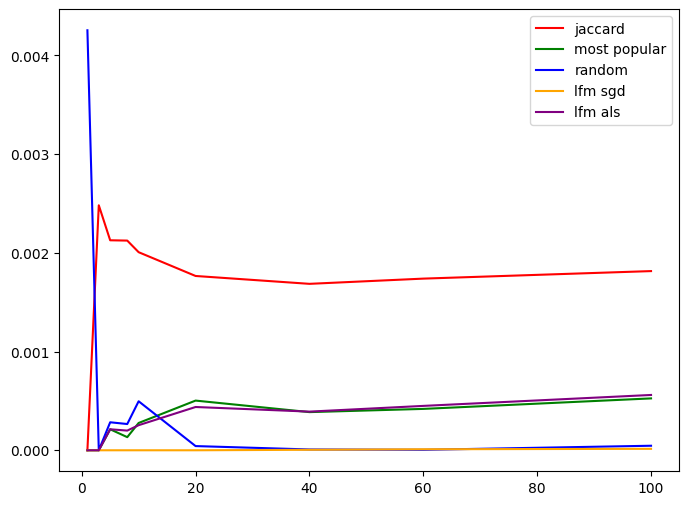

In [ ]:
fig = plt.figure(figsize=(8, 6), dpi = 100)

plt.plot(k_grid, mapk_history_jaccard, color='r', label='jaccard')
plt.plot(k_grid, mapk_history_popular, color='g', label='most popular')
plt.plot(k_grid, mapk_history_random, color='b', label='random')
plt.plot(k_grid, mapk_history_lfm_sgd, color ='orange', label = 'lfm sgd')
plt.plot(k_grid, mapk_history_lfm_als, color ='purple', label = 'lfm als')

plt.legend()

fig.show()

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [ ]:
model = lfm_als
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q.T @ model.Q.T[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=0) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [ ]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q.T[example_trackId])
similar_tracks

,name,artists,similarity
2814,Numb,['Linkin Park'],1.000000
1073,Smells Like Teen Spirit,['Nirvana'],0.999999
805,Zombie,['The Cranberries'],0.999999
24500,Way Down We Go,['KALEO'],0.999999
7533,Highway to Hell,['AC/DC'],0.999999
11493,The Show Must Go On,['Queen'],0.999999
8263,Shape Of My Heart,['Sting'],0.999999
18459,Take Me To Church,['Hozier'],0.999999
6376,"You're Gonna Go Far, Kid",['The Offspring'],0.999999
1019,It's My Life,['Bon Jovi'],0.999999


sgd нормально так и не заработал, als отрабатывает штатно, рекомендует популярное, т.к. не имеет frequency-based регуляризации

**Бонус (1.5 балла).**

Постройте модель iALS и сравните ее качество с обучением ALS и SGD.

In [ ]:
# your code here: (￣▽￣)/♫•*¨*•.¸¸♪

### Часть 3. Второй уровень рекомендаций.

Выше мы построили простейшие модели, которые показывают не слишком высокое качество, но зато работают очень быстро. Воспользуемся ими для того, чтобы отобрать некоторое количество наиболее перспективных треков, которые мы сможем отранжировать уже более сложной моделью (в нашем случае это будет [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboost)).

**Задание 9 (1 балл).**

Для каждого пользователя возьмите топ-100 рекомендованных треков от модели LFM (ALS или SGD на ваш выбор) и топ-100 от модели User2User. Это будут наши кандидаты, которые мы затем будем ранжировать бустингом.

In [ ]:
u2u_top_100 = u2u.get_test_recommendations(100)
lfm_top_100 = lfm_als.get_test_recommendations(100)

**Задание 10 (2 балла).**

Подготовьте датасет для обучения модели ранжирования. Он должен состоять из пар: объект, целевая переменная. Объект - это пара (user, item) и всякие дополнительные признаки на их основе. Предлагается создать набор следущих признаков, однако вы можете добавлять свои по желанию, если они вам кажутся разумными:
 1) id пользователя
 1) id трека
 1) косинусное расстояние между эмбеддингами LFM соответствующих пользователя и трека
 1) среднее значение меры Жаккара между этим пользователем и остальными из User2User модели
 1) доля пользователей, слушавших этот трек (взять из обучающей выборки в Части 1)
 1) количество прослушанных пользователем треков (взять из обучающей выборки в Части 1)

В качестве целевой переменной возьмем бинарную метку "попал ли трек в 50 последних прослушанных пользователем"

Разбейте полученную выборку на обучающую и тестовую в отношении 3:2 так, чтобы пропорции положительных и отрицательных примеров в обоих подвыборках были одинаковыми.

In [ ]:
from scipy.spatial import distance
P = lfm_als.P.T
Q = lfm_als.Q.T
R = u2u.R

dct = {'user_id':[], 'track_id':[], 'cosine_d':[], 'avg_jaccard':[], 'listened_share':[], 'listened_tracks':[], 'target':[]}

for user_id, track_ids in enumerate(u2u_top_100):
  avg_jaccard = np.mean(jaccard(R, R[user_id]))
  listened_tracks = train_ratings[train_ratings['userId'] == user_id].shape[0]
  test_tracks = test_ratings[test_ratings['userId'] == user_id]['trackId']
  for track_id in track_ids: 
    dct['user_id'].append(user_id)
    dct['track_id'].append(track_id)
    dct['cosine_d'].append(distance.cosine(P[user_id], Q[track_id]))
    dct['avg_jaccard'].append(avg_jaccard)
    dct['listened_share'].append(train_ratings[train_ratings['trackId'] == track_id].shape[0]/R.shape[0])
    dct['listened_tracks'].append(listened_tracks)
    dct['target'].append(track_id in test_tracks)

for user_id, track_ids in enumerate(lfm_top_100):
  avg_jaccard = np.mean(jaccard(R, R[user_id]))
  listened_tracks = train_ratings[train_ratings['userId'] == user_id].shape[0]
  test_tracks = test_ratings[test_ratings['userId'] == user_id]['trackId']
  for track_id in track_ids: 
    dct['user_id'].append(user_id)
    dct['track_id'].append(track_id)
    dct['cosine_d'].append(distance.cosine(P[user_id], Q[track_id]))
    dct['avg_jaccard'].append(avg_jaccard)
    dct['listened_share'].append(train_ratings[train_ratings['trackId'] == track_id].shape[0]/R.shape[0])
    dct['listened_tracks'].append(listened_tracks)
    dct['target'].append(track_id in test_tracks)
    
df = pd.DataFrame(dct)
df = df.sort_values(by = 'user_id')
df

,user_id,track_id,cosine_d,avg_jaccard,listened_share,listened_tracks,target
0,0,4507,3.920619e-09,0.005478,0.037344,206,False
24126,0,48182,5.851636e-10,0.005478,0.136929,206,False
24127,0,43228,2.012821e-09,0.005478,0.103734,206,False
24128,0,22325,5.946313e-10,0.005478,0.124481,206,False
24129,0,32901,1.577344e-09,0.005478,0.124481,206,False
...,...,...,...,...,...,...,...
24070,240,20976,7.836376e-11,0.006056,0.008299,1668,False
24071,240,16923,7.836376e-11,0.006056,0.008299,1668,False
24072,240,44269,7.162156e-10,0.006056,0.033195,1668,False
24062,240,33436,6.444923e-09,0.006056,0.161826,1668,False


In [ ]:
target_false = df[df.target == False]
target_true = df[df.target == True]

target_false_train = target_false.sample(frac = 3/5)
target_false_test = target_false[~target_false.index.isin(target_false_train.index)]

target_true_train = target_true.sample(frac = 3/5)
target_true_test = target_true[~target_true.index.isin(target_true_train.index)]

X_train = target_false_train.append(target_true_train, ignore_index = True)
X_test = target_false_test.append(target_true_test, ignore_index = True)

X_train = X_train.sort_values(by = 'user_id')
X_test = X_test.sort_values(by = 'user_id')

y_train = X_train['target']
train_group_id = X_train['user_id']
X_train = X_train.drop('target', axis = 1)

y_test = X_test['target']
test_group_id = X_test['user_id']
X_test = X_test.drop('target', axis = 1)

X_train, y_train, train_group_id, X_test, y_test, test_group_id

In [ ]:
y_train[y_train == True].shape[0] / y_train.shape[0]

0.0008990318118948824

In [ ]:
y_test[y_test == True].shape[0] / y_test.shape[0]

0.0009336099585062241

Как уже было сказано, для построения ранжирующей модели мы будем пользоваться библиотекой [CatBoost](https://www.youtube.com/watch?v=dQw4w9WgXcQ). 

Для преобразования датасета в удобный вид полезно использовать метод [`Pool`](https://catboost.ai/en/docs/concepts/python-reference_pool).

In [ ]:
!pip install catboost

In [ ]:
import catboost

# group_id == user_id here
train_pool = catboost.Pool(X_train, y_train, group_id = pd.Series(train_group_id))
test_pool = catboost.Pool(X_test, y_test, group_id = pd.Series(test_group_id))

**Задание 11 (1 балл)**

Обучите `CatBoostClassifier`. С его помощью сделайте предсказания для тестовой выборки и посчитайте MAP@20. Сравните с рекомендациями моделей User2User и LFM. Учтите, что для честного сравнения необходимо пересчитать предсказания моделей на нашей новой тестовой выборке. Получилось ли улучшить результаты?

In [ ]:
cls = catboost.CatBoostClassifier()

cls.fit(train_pool)
preds = cls.predict_proba(test_pool)

In [ ]:
cbt_predictions = []

test_ids = test_group_id.reset_index()

for user_id in test_ids['user_id'].unique():
  sorted_preds = np.argsort(-preds[:, 1][test_ids['user_id'] == user_id])[:20]
  track_predictions_idx = test_ids[test_ids['user_id'] == user_id].iloc[sorted_preds]['index'].to_numpy()
  predicted_tracks = X_test.iloc[track_predictions_idx]['track_id'].to_numpy()
  cbt_predictions.append(predicted_tracks)

cbt_predictions

In [ ]:
mapk(test_relevant, cbt_predictions, 20)

0.0006694286581316422

In [ ]:
mapk_history_jaccard[5]

0.001765962631164199

In [ ]:
mapk_history_lfm_als[5]

0.00043849820995595323

сделано было следующим образом: берем 200 пресказаний моделей первого уровня для каждого пользователя, строим датасет как описано в задании 10, делим на тест и трейн, обучаем catboost classifier, берем для каждого пользователя по 20 наиболее вероятных треков с точни зрения classifier'a, считаем для этого map@20


качество по сравнению с lfm als удалось улучшить, jaccard все еще недостижим

**Задание 12 (1 балл)**

Обучите `CatBoostRanker`, выбрав подходящую функцию ранжирования из тех, которые были рассмотрены на лекции. Проделайте все те же действия, что и с `CatBoostClassifier` и сравните результаты.

In [ ]:
ranker = catboost.CatBoostRanker(custom_metric = "PFound")

cls.fit(train_pool)
preds = cls.predict_proba(test_pool)

In [ ]:
ranker_predictions = []

test_ids = test_group_id.reset_index()

for user_id in test_ids['user_id'].unique():
  sorted_preds = np.argsort(-preds[:, 1][test_ids['user_id'] == user_id])[:20]
  track_predictions_idx = test_ids[test_ids['user_id'] == user_id].iloc[sorted_preds]['index'].to_numpy()
  predicted_tracks = X_test.iloc[track_predictions_idx]['track_id'].to_numpy()
  ranker_predictions.append(predicted_tracks)

ranker_predictions

In [ ]:
mapk(test_relevant, ranker_predictions, 20)

0.0006694286581316422

In [ ]:
mapk_history_jaccard[5]

0.001765962631164199

In [ ]:
mapk_history_lfm_als[5]

0.00043849820995595323

короче, смэрть 
